In [1]:
import h5py
import numpy as np
from tqdm import tqdm
from joblib import load
import matplotlib.pyplot as plt
from numpy.polynomial import legendre as L
import torch
from torch import nn
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('tableau-colorblind10')

In [2]:
weight_path = 'weight/'

The VAE model

In [3]:
class VAE(nn.Module):
    def __init__(self, input_size, num_hidden1=512, num_hidden2=256, num_hidden3=128, code_size=4, drop_rate=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, num_hidden1),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden1, num_hidden2),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden2, num_hidden3),nn.PReLU(),nn.Dropout(p=drop_rate)
        )
        self.hidden2mu = nn.Linear(num_hidden3, code_size)
        self.hidden2log_var = nn.Linear(num_hidden3, code_size)
        self.decoder = nn.Sequential(
            nn.Linear(code_size, num_hidden3),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden3, num_hidden2),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden2, num_hidden1),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden1, input_size)
        )

    def reparameterization(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            epsilon = torch.randn_like(std)
            z = mu + std*epsilon
            return z
        else:
            return mu

    def forward(self, x):
        x = self.encoder(x)
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        z = self.reparameterization(mu, log_var)
        x = self.decoder(z)
        return x, mu, log_var

In [4]:
def poly_fit(wave, flux, order=4, num_iter=5, high=2., low=2.):
    cont = np.zeros_like(flux)
    w = np.ones_like(flux)
    for idx in tqdm(range(len(flux)), position=0, leave=True):
        for i in range(num_iter):
            coeffs = L.legfit(wave, flux[idx], order, w=w[idx])
            cont[idx] = L.legval(wave, coeffs)
            std = np.std(flux[idx][w[idx]==1]-cont[idx][w[idx]==1])
            w[idx][flux[idx]>cont[idx]+high*std] = 0
            w[idx][flux[idx]<cont[idx]-low*std] = 0
    return cont, w

Loading data

In [5]:
fhdemo = h5py.File('data/demo_spec.h5', 'r')
flux_ha = fhdemo['flux_ha_R1800'][...]
flux_ca = fhdemo['flux_ca_R1800'][...]
flux_R250 = fhdemo['flux_R250'][...]
fhdemo.close()

wave_ha = np.linspace(6371,6770,400)
wave_ca = np.linspace(8381,8780,400)
wave_R250 = np.linspace(6005,7500,300)

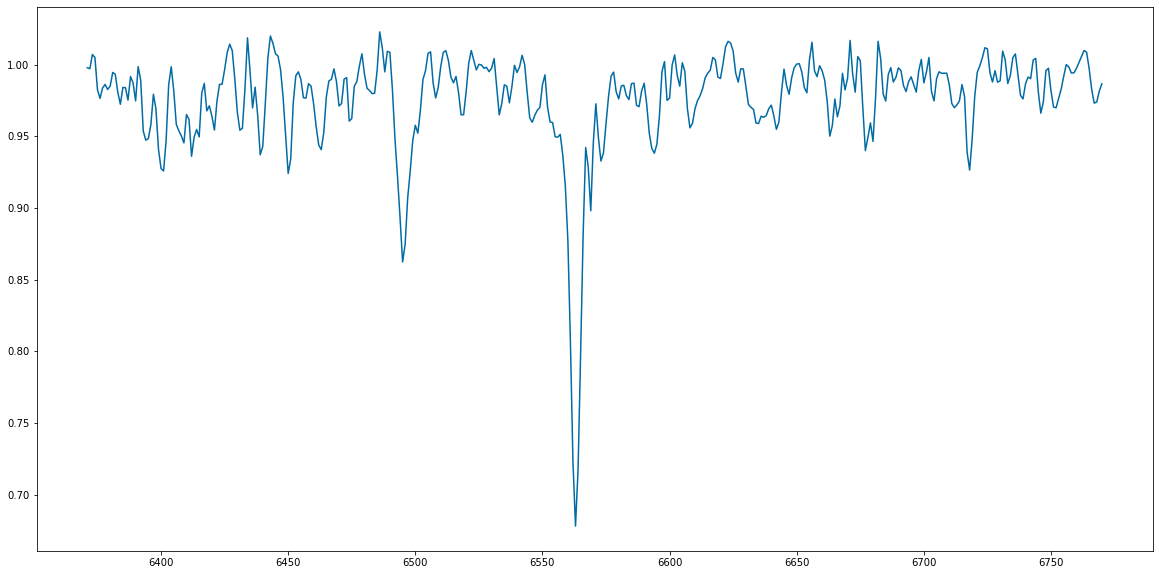

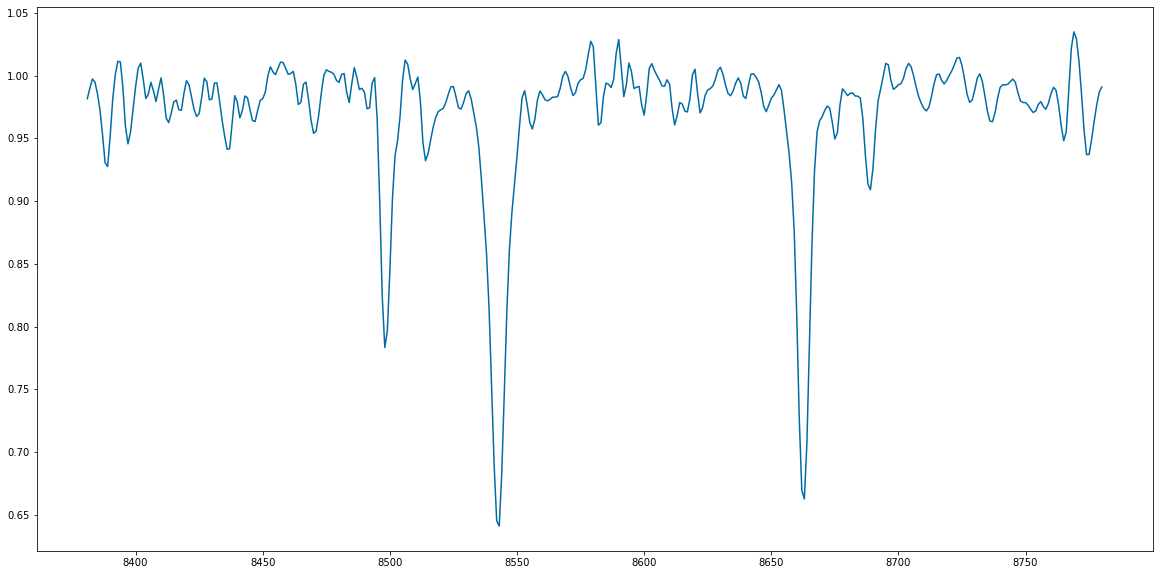

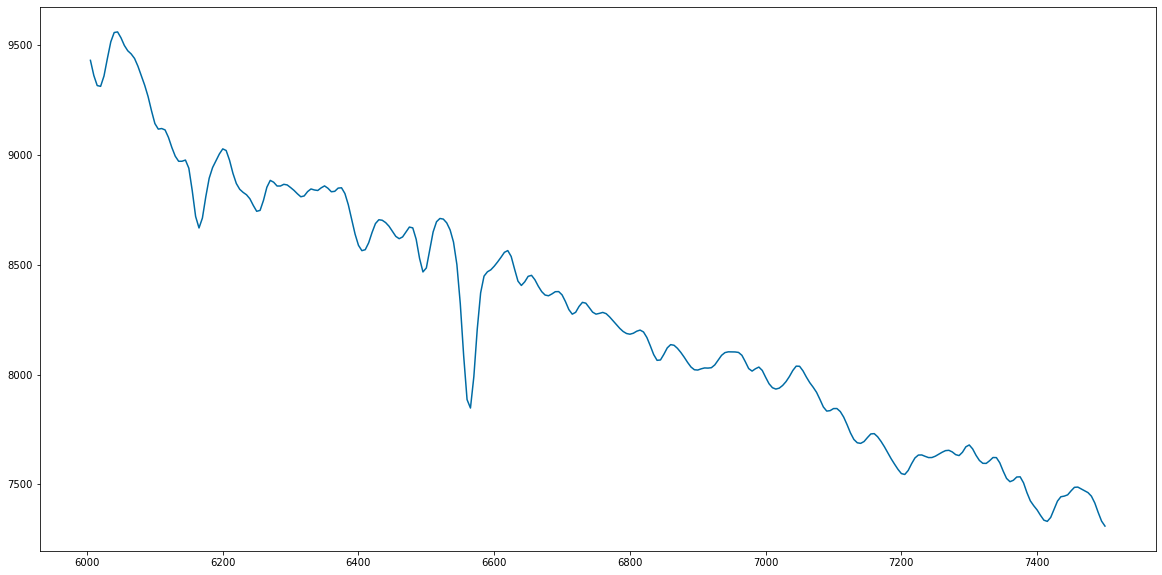

In [6]:
idx = 0
plt.plot(wave_ha, flux_ha[idx])
plt.show()
plt.plot(wave_ca, flux_ca[idx])
plt.show()
#plt.plot(wave, flux[idx])
plt.plot(wave_R250, flux_R250[idx])
plt.show()

Loading the model weights

In [7]:
code_size = 4
input_size_R1800 = len(wave_ha) + len(wave_ca)
input_size_R250 = len(wave_R250)

model_R1800 = VAE(input_size=input_size_R1800, code_size=code_size).to(device)
model_R250 = VAE(input_size=input_size_R250, code_size=code_size).to(device)

model_R1800.load_state_dict(torch.load(weight_path + 'model_R1800.pt', map_location=device))
model_R250.load_state_dict(torch.load(weight_path + 'model_R250.pt', map_location=device)) 

model_R1800 = model_R1800.to(device)
model_R250 = model_R250.to(device)

Loading the standard scaler

In [8]:
sc_R1800 = load(weight_path + 'sc_R1800.joblib')
sc_R250 = load(weight_path + 'sc_R250.joblib')

Concatenating H$\alpha$ and Ca II IRT bands to contruct the input of R1800 spectra

In [9]:
flux_R1800 = np.concatenate([flux_ha, flux_ca], axis=1)
wave_R1800 = np.concatenate([wave_ha, wave_ca])

Normalizing R250 spectra: divide R250 spectra by the median flux in range of 6500--6550 $\mathring A$

In [10]:
sec_norm = (wave_R250>=6500.) & (wave_R250<=6550.)
norm = np.median(flux_R250[:, sec_norm], axis=1, keepdims=True)
flux_R250_norm = flux_R250 / norm

Model inference

In [11]:
flux_input_R1800 = sc_R1800.transform(flux_R1800)
flux_input_R250 = sc_R250.transform(flux_R250_norm)
flux_input_R1800 = torch.Tensor(flux_input_R1800.astype(np.float32))
flux_input_R250 = torch.Tensor(flux_input_R250.astype(np.float32))
flux_input_R1800 = flux_input_R1800.to(device)
flux_input_R250 = flux_input_R250.to(device)
model_R1800.eval()
model_R250.eval()
flux_vae_R1800, mu_R1800, log_var_R1800 = model_R1800(flux_input_R1800)
flux_vae_R250, mu_R250, log_var_R250 = model_R250(flux_input_R250)

flux_vae_R1800 = flux_vae_R1800.cpu().detach().numpy()
flux_vae_R250 = flux_vae_R250.cpu().detach().numpy()

flux_vae_R1800 = sc_R1800.inverse_transform(flux_vae_R1800)
flux_vae_R250 = sc_R250.inverse_transform(flux_vae_R250)

flux_vae_ha = flux_vae_R1800[:, :len(wave_ha)]
flux_vae_ca = flux_vae_R1800[:, len(wave_ca):]

Plot some examples

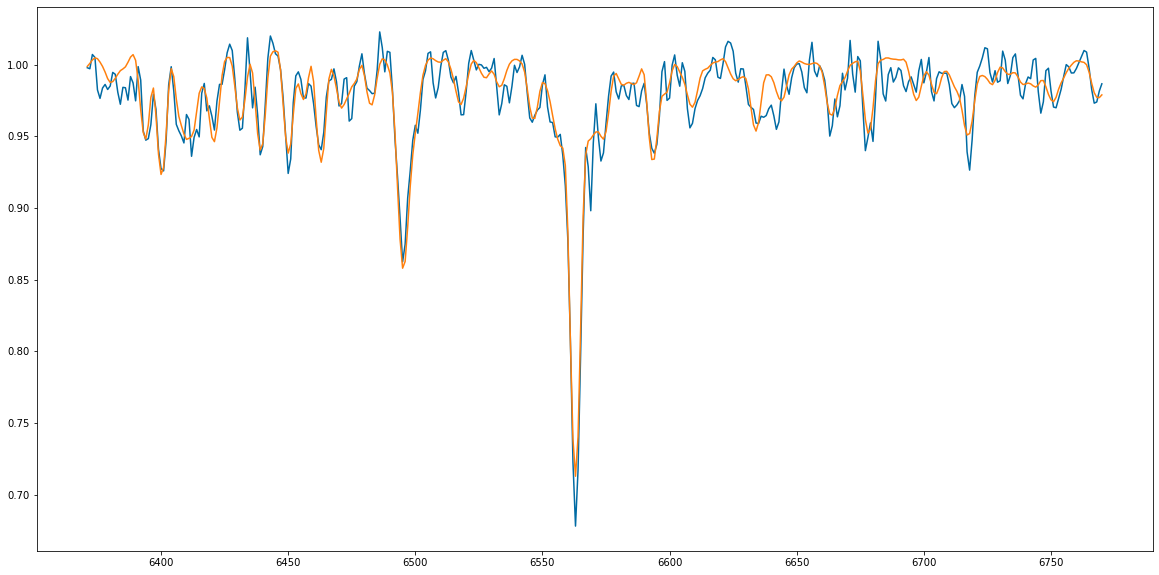

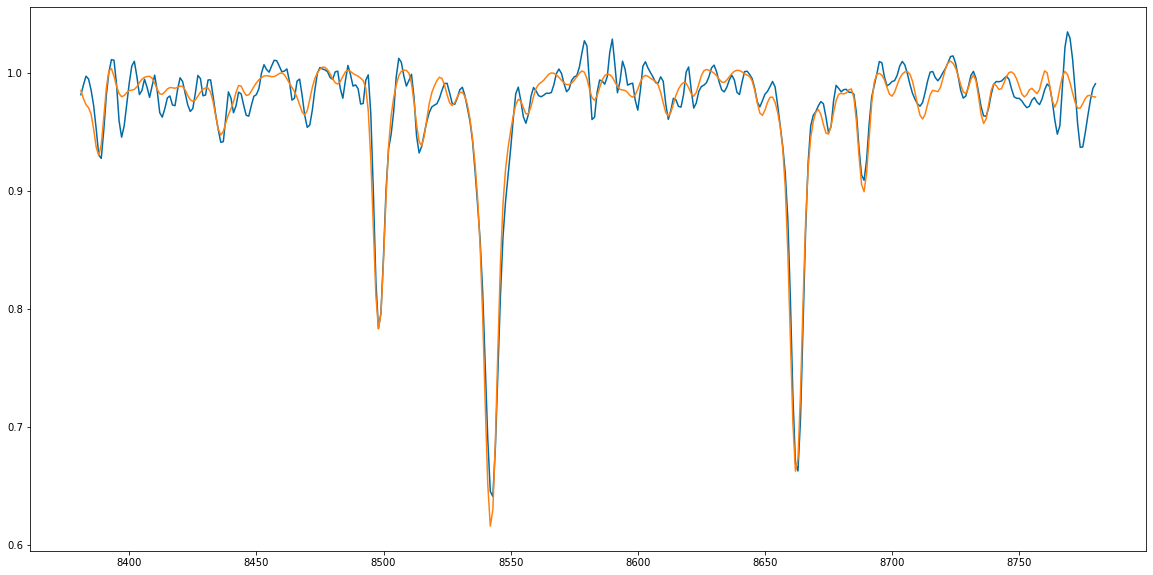

In [12]:
idx = 0
plt.plot(wave_ha, flux_ha[idx])
plt.plot(wave_ha, flux_vae_ha[idx])
plt.show()
plt.plot(wave_ca, flux_ca[idx])
plt.plot(wave_ca, flux_vae_ca[idx])
plt.show()

Minor correction on R250 spectra and showing result

In [13]:
ratio = flux_R250_norm / flux_vae_R250
num_iter = 5
order = 3
high_sigma = 2.
low_sigma = 2.
corr, w = poly_fit(wave_R250, ratio, order=3, num_iter=num_iter, high=high_sigma, low=low_sigma)
flux_R250_corr = flux_R250_norm / corr

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 973.44it/s]


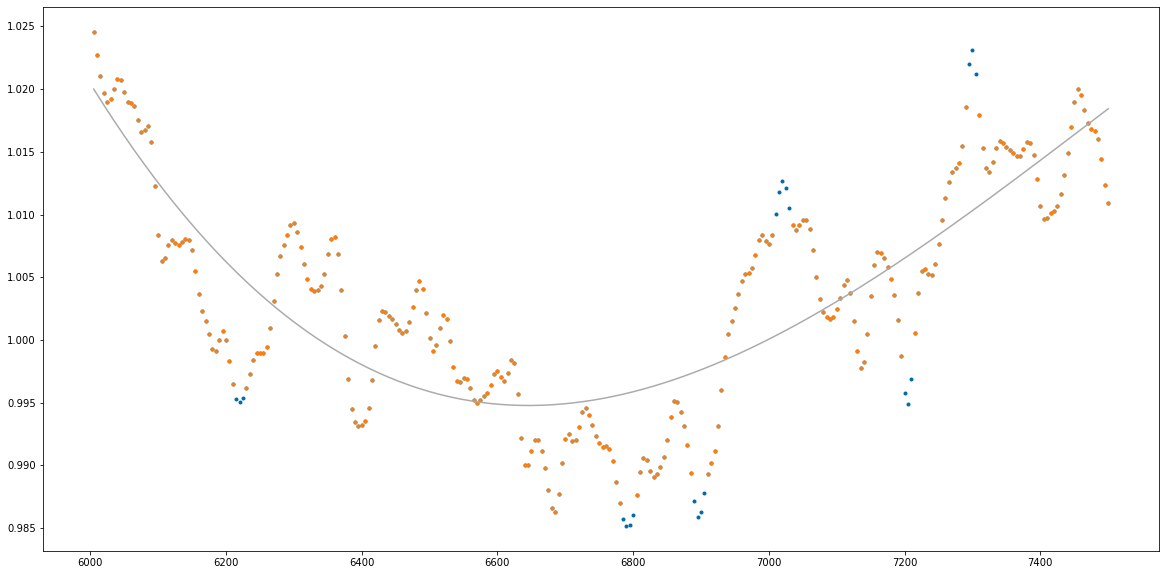

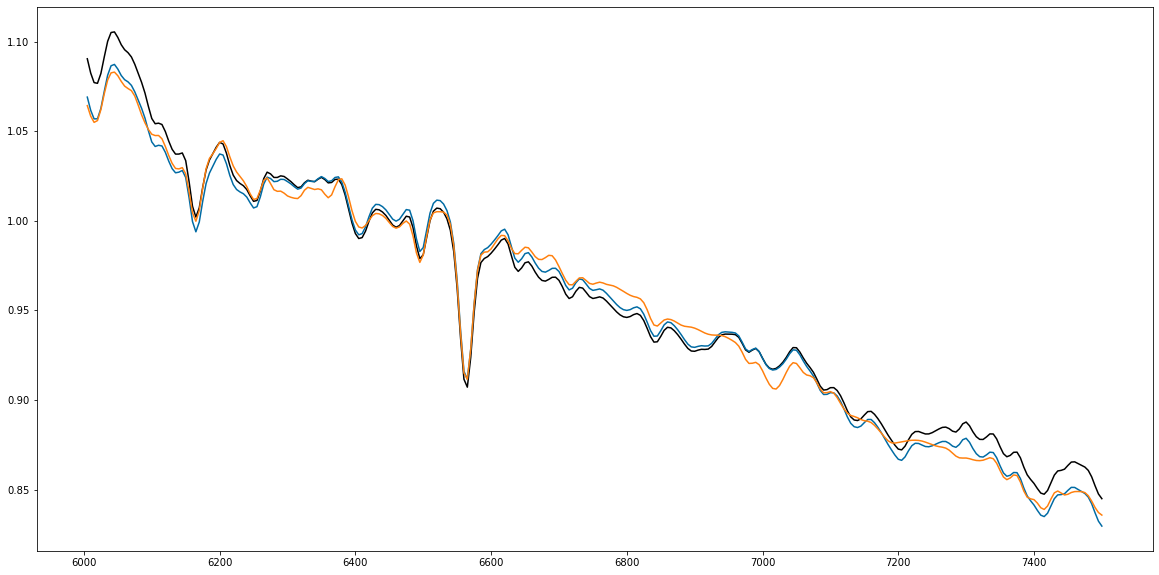

In [14]:
idx = 0
plt.plot(wave_R250, ratio[idx], '.')
plt.plot(wave_R250[w[idx]==1], ratio[idx][w[idx]==1], '.')
plt.plot(wave_R250, corr[idx])
plt.show()
plt.plot(wave_R250, flux_R250_norm[idx], 'k')
plt.plot(wave_R250, flux_R250_corr[idx])
plt.plot(wave_R250, flux_vae_R250[idx])
plt.show()

Plotting examples

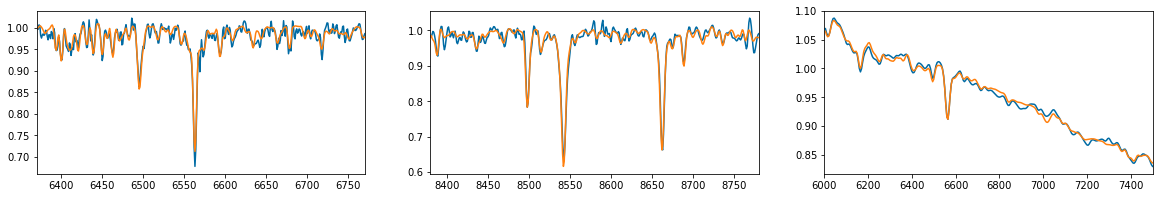

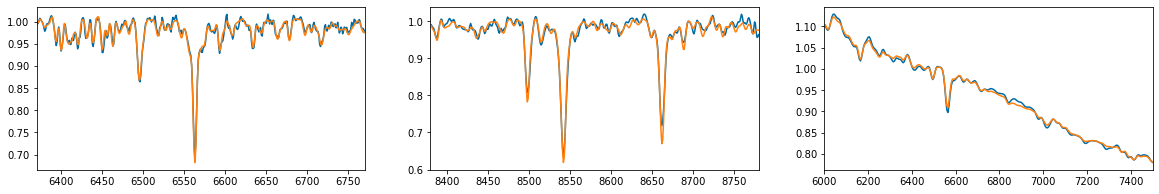

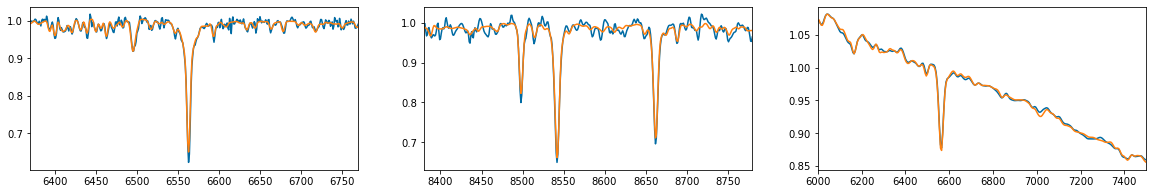

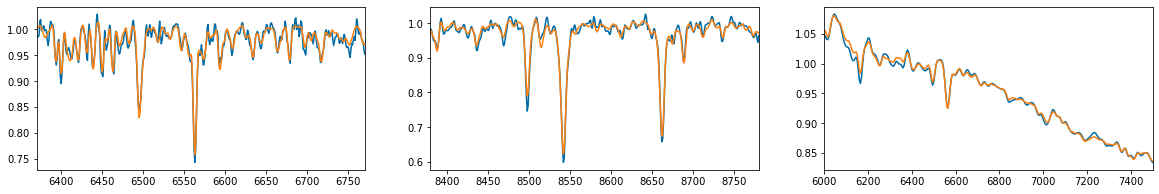

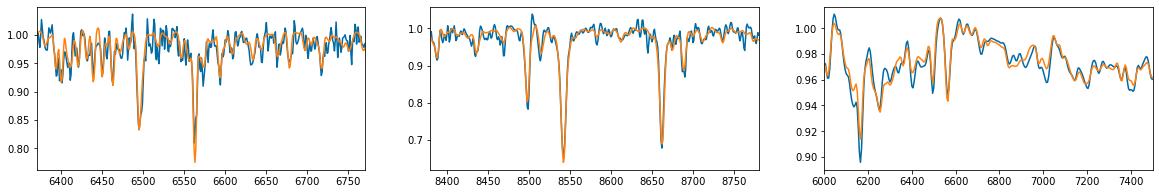

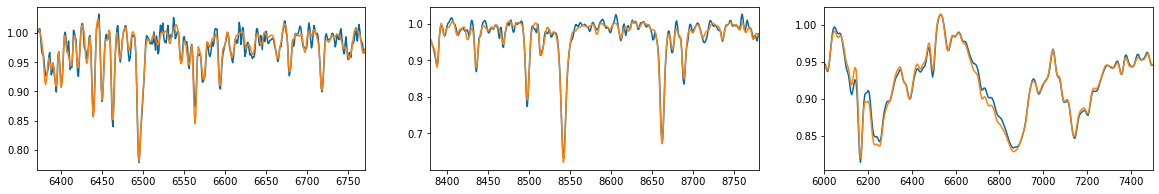

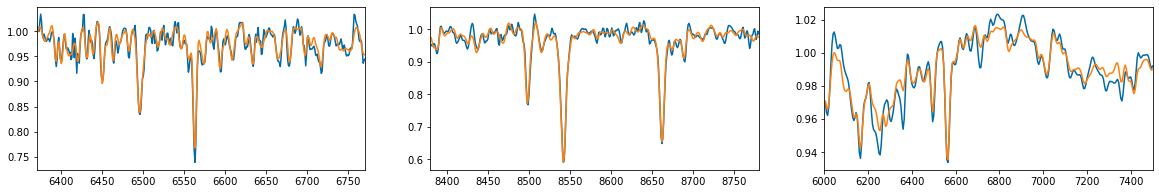

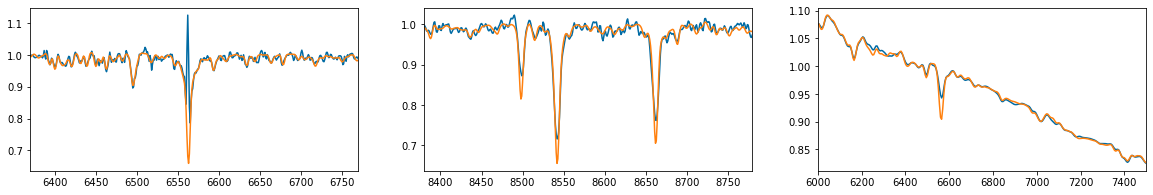

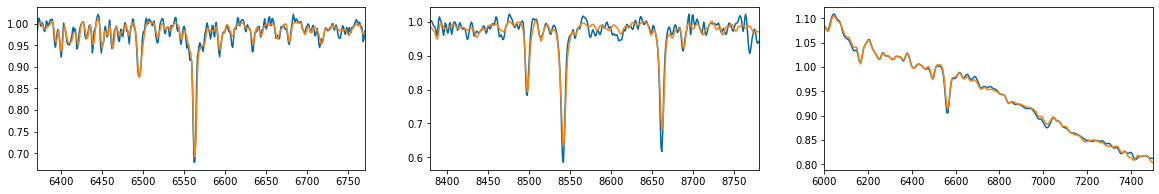

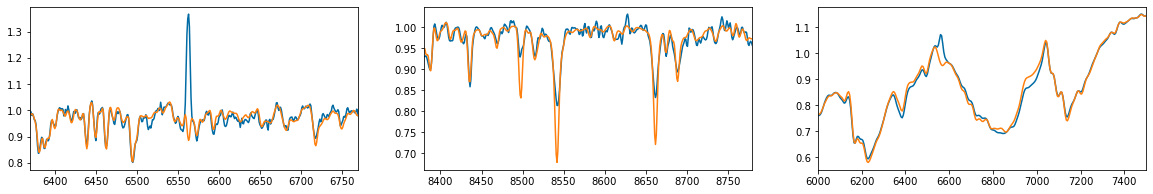

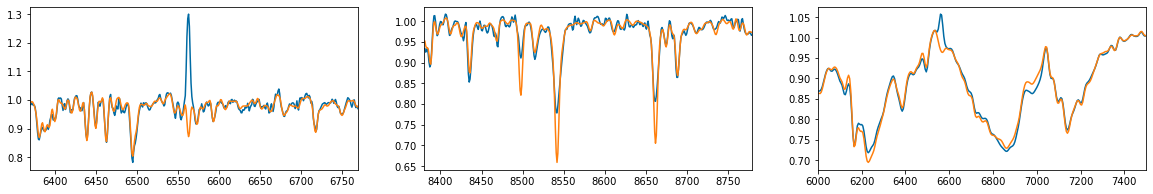

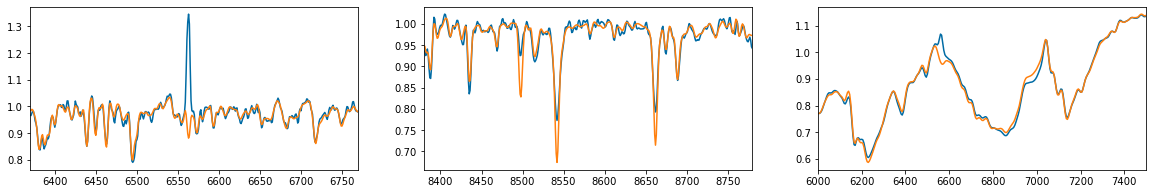

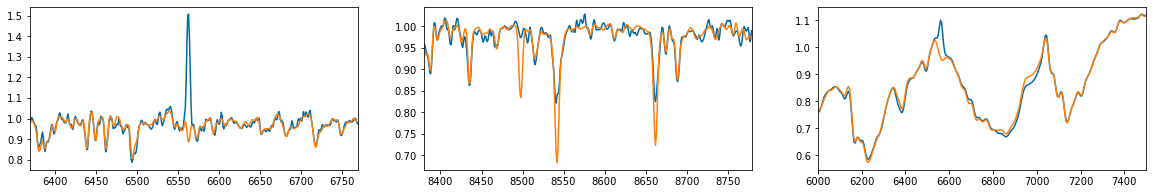

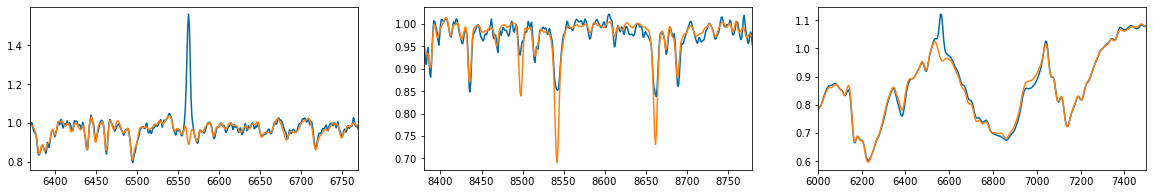

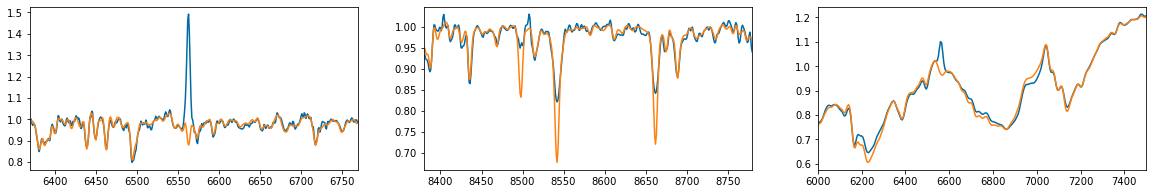

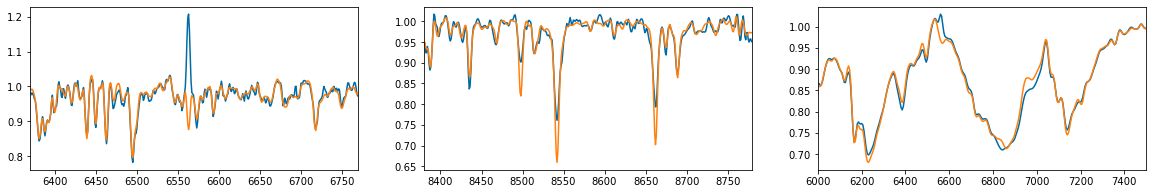

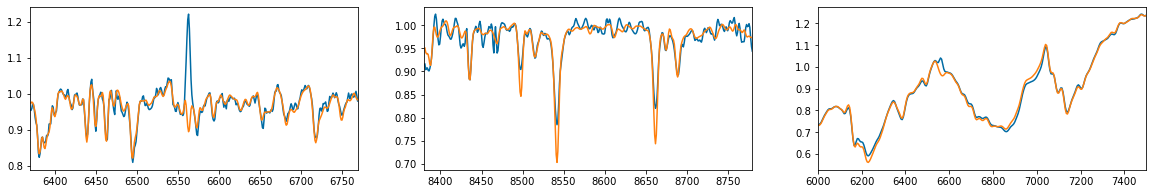

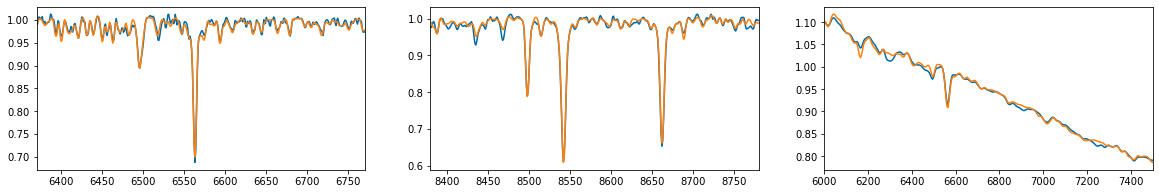

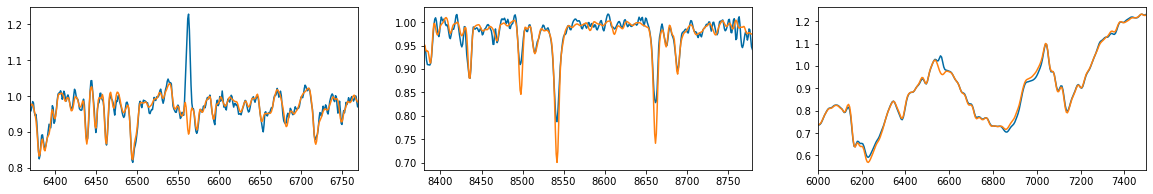

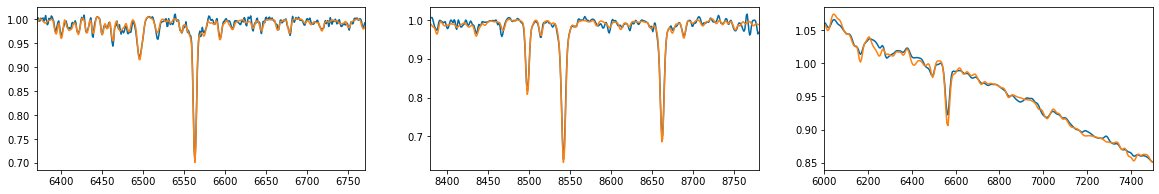

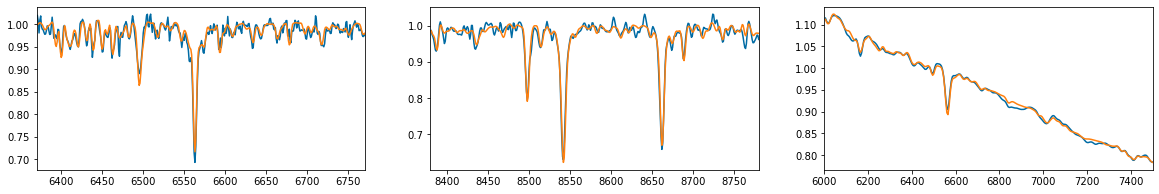

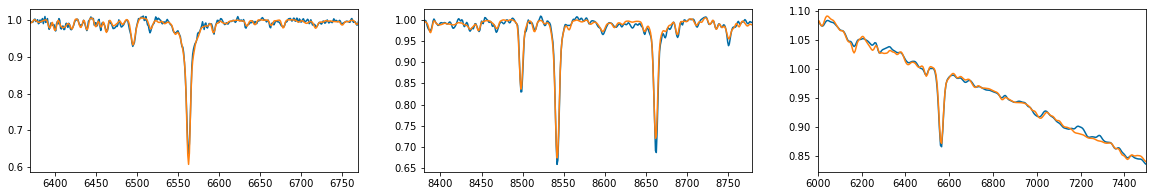

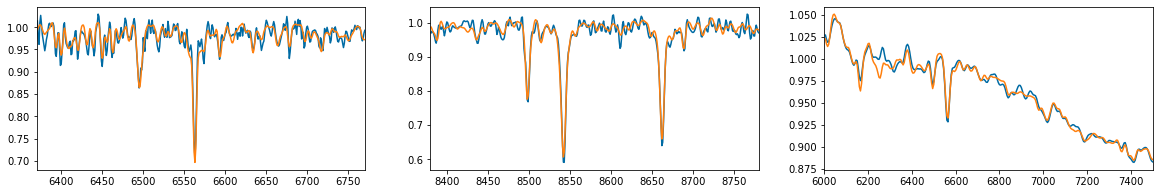

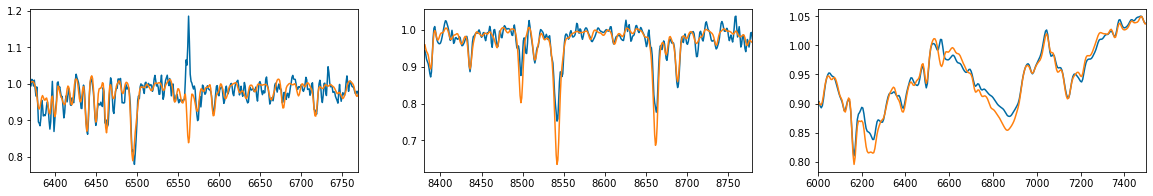

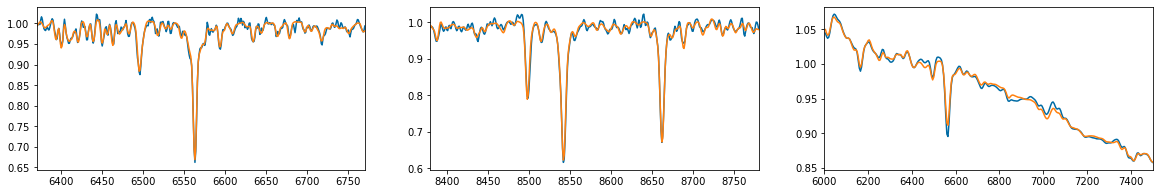

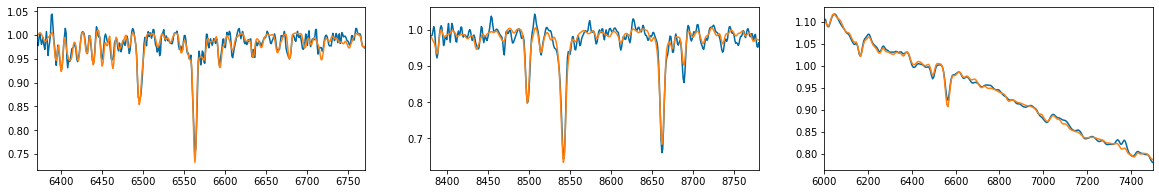

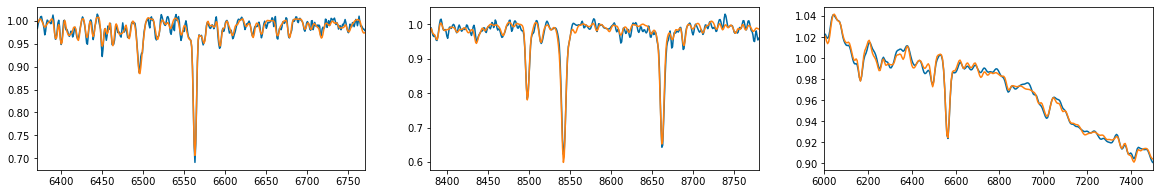

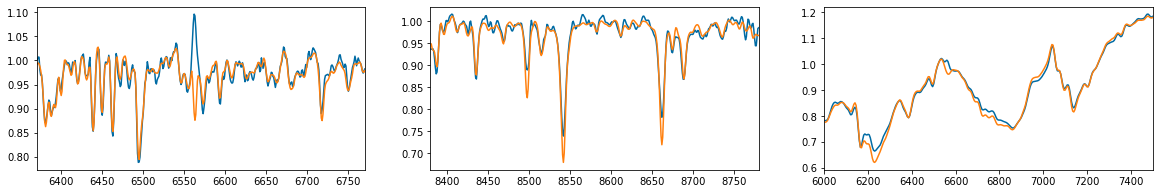

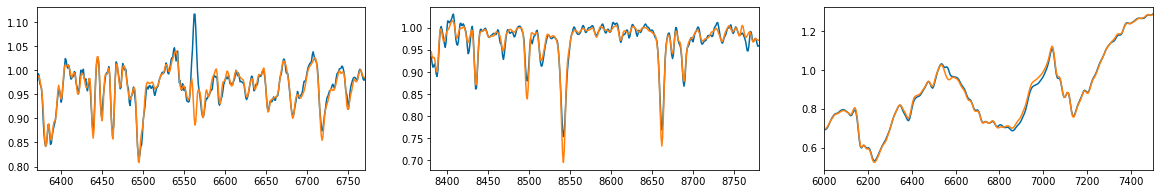

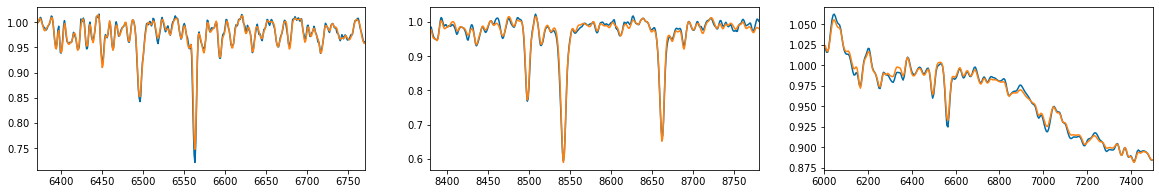

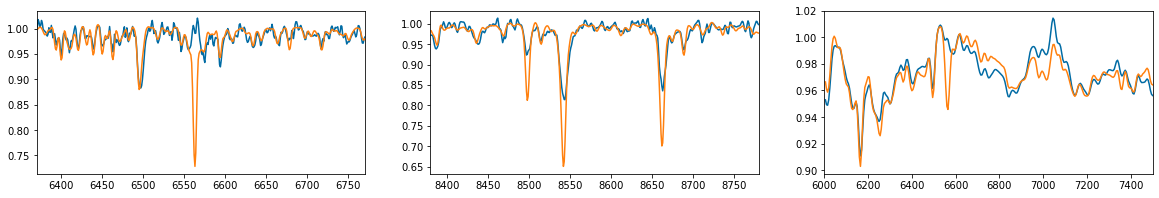

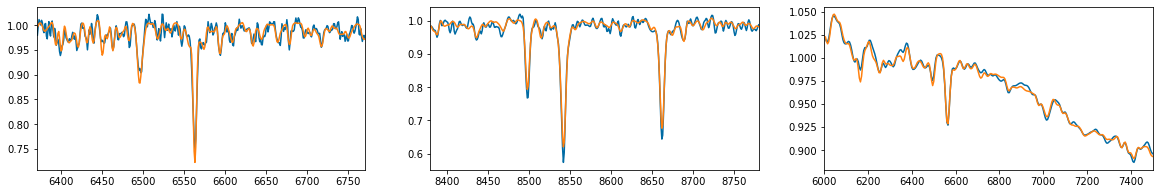

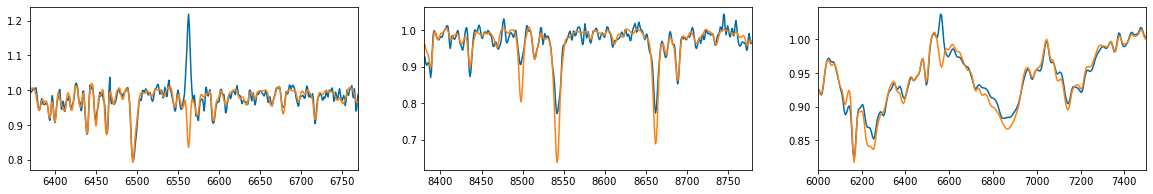

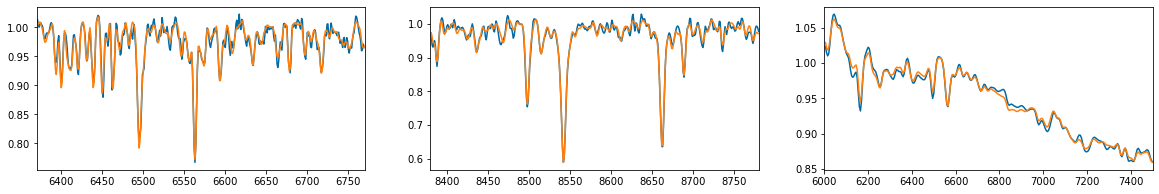

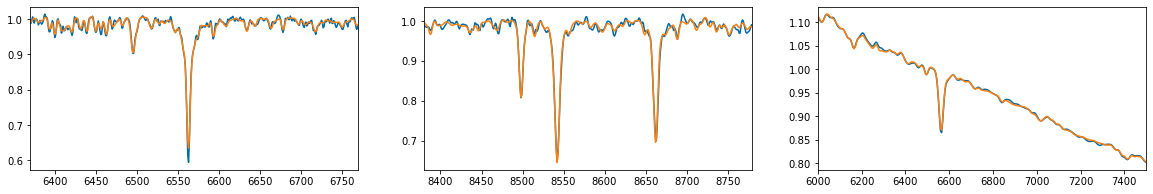

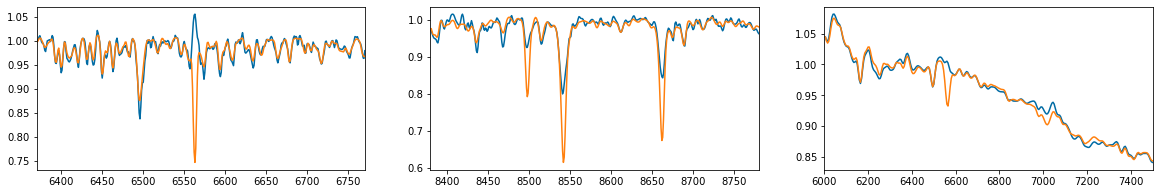

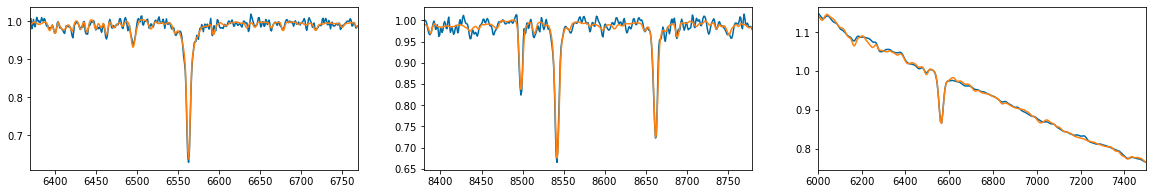

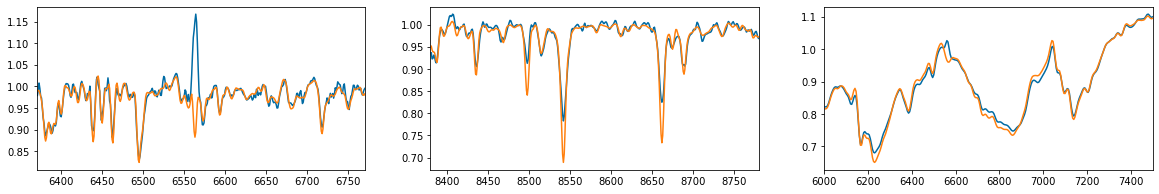

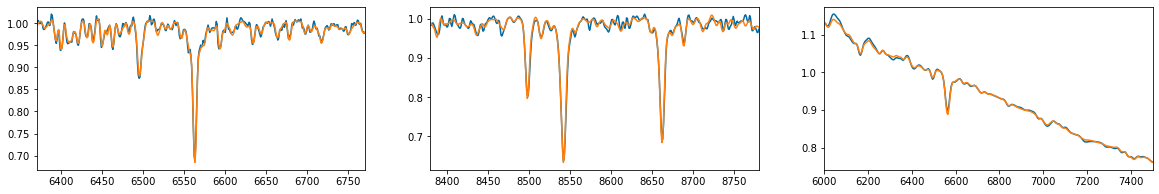

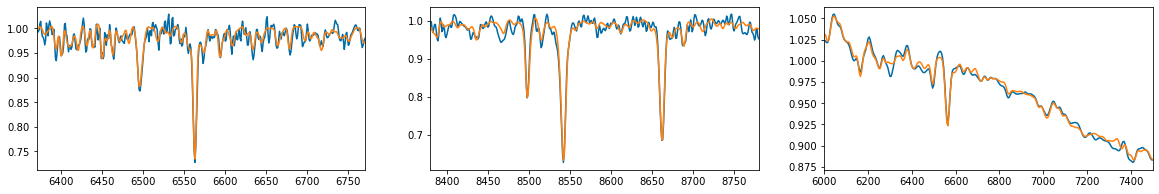

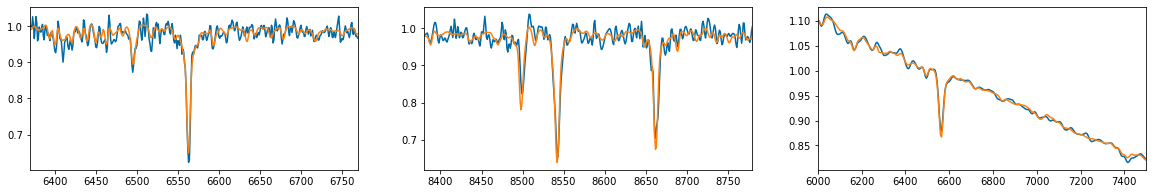

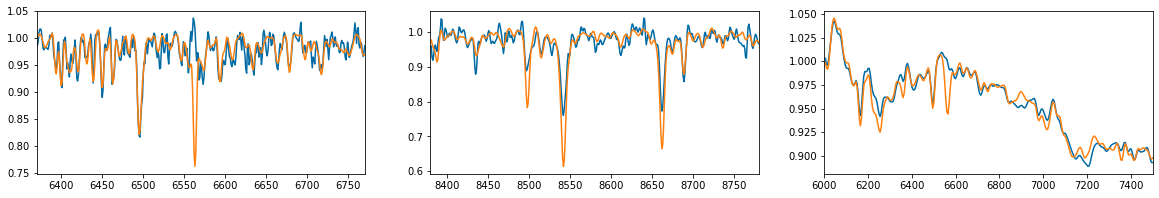

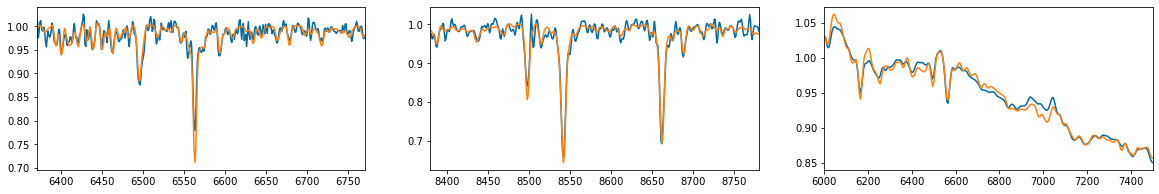

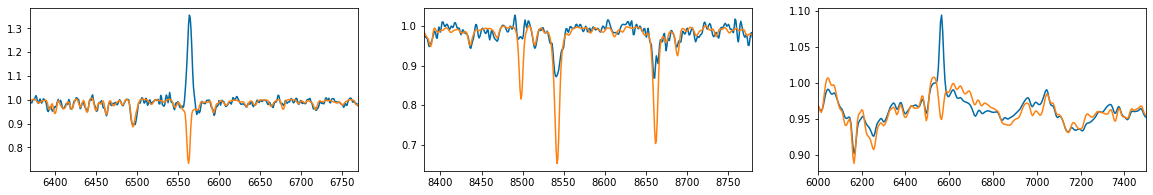

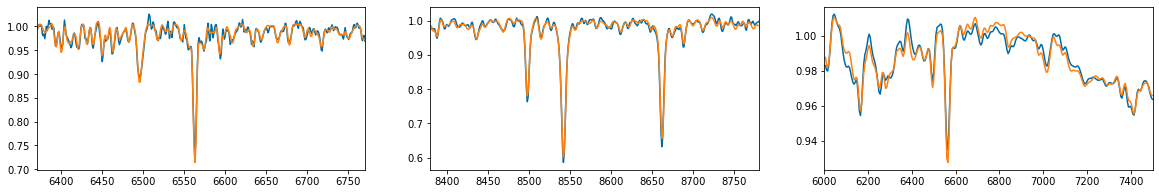

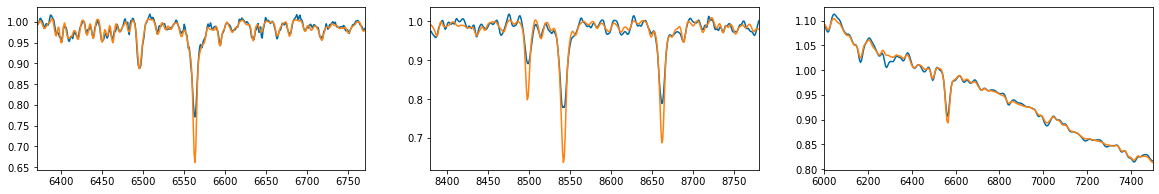

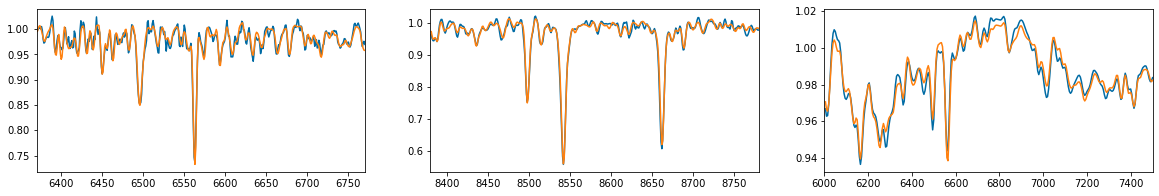

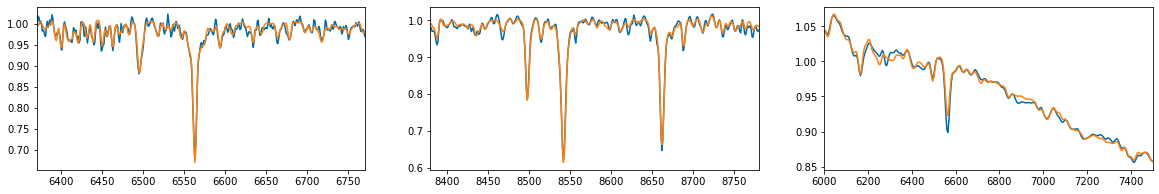

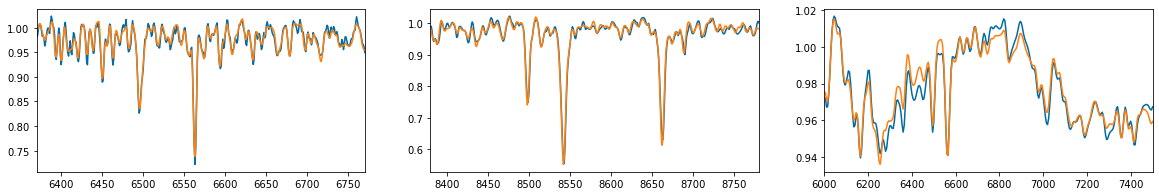

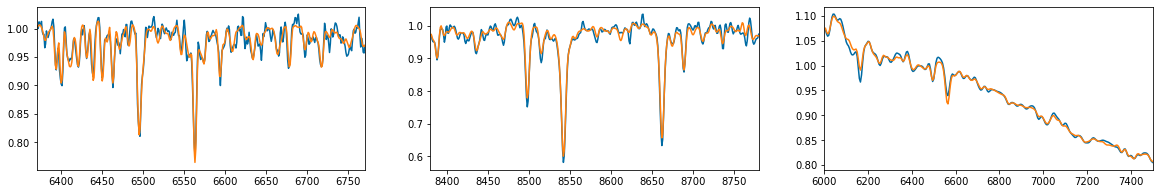

In [15]:
for idx in range(50):
    fig = plt.figure(figsize=(20,3))
    ax1 = fig.add_subplot(131)
    ax1.plot(wave_ha, flux_ha[idx])
    ax1.plot(wave_ha, flux_vae_ha[idx])
    ax1.set_xlim(6370., 6770.)
    ax2 = fig.add_subplot(132)
    ax2.plot(wave_ca, flux_ca[idx])
    ax2.plot(wave_ca, flux_vae_ca[idx])
    ax2.set_xlim(8380., 8780.)
    ax3 = fig.add_subplot(133)
    ax3.plot(wave_R250, flux_R250_corr[idx])
    ax3.plot(wave_R250, flux_vae_R250[idx])
    ax3.set_xlim(6000., 7500.)
    plt.show()